In [1]:
import torch
from utils.construct_tff import construct_real_tff
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
x = torch.tensor([-1, -0.5, 0.5, 1]).view(-1,1)
print(f'evergy x = {(x**2).sum() }')
noise_std = torch.sqrt(0.1 *(x**2).sum() )
print(f'energy noise = {noise_std ** 2}')

evergy x = 2.5
energy noise = 0.25


In [9]:
l = 2
n = 4
k = 3
tff = construct_real_tff(k, l// 2, n // 2)
coefs = torch.matmul(tff, x)
print(coefs.shape)
projs = torch.matmul(tff.permute(0,2,1), coefs)
print(projs)
print(projs.shape)
print(projs.sum(dim=0))


torch.Size([3, 2, 1])
tensor([[[-0.1667],
         [ 0.1667],
         [-0.1667],
         [ 0.1667]],

        [[-0.7053],
         [-0.1890],
         [ 0.1890],
         [ 0.7053]],

        [[-0.1280],
         [-0.4777],
         [ 0.4777],
         [ 0.1280]]])
torch.Size([3, 4, 1])
tensor([[-1.0000],
        [-0.5000],
        [ 0.5000],
        [ 1.0000]])


In [ ]:
-0.1667 \\
 0.1667 \\
-0.1667 \\
 0.1667

-0.7053 \\
-0.1890 \\
 0.1890 \\
 0.7053

-0.1280 \\
-0.4777 \\
 0.4777 \\
 0.1280

In [152]:
redundancies = [1, 1.25, 1.5, 1.75, 2.0]
mse_reduction = []

l = 2
n = 4
g = torch.Generator()
g.manual_seed(50)
rand_mat_u = torch.randn((n, n), generator=g)
Q_u, _ = torch.linalg.qr(rand_mat_u)
for r in redundancies:
    k = int(2 * r)
    tff = construct_real_tff(k, l// 2, n // 2).view(-1, n)  @ Q_u
    projs = tff @ x
    projs = projs.view(-1,1)
    tru_noise_energys = []
    final_noise_energys = []
    for i in range(10000):
        ns = torch.randn_like(projs) * noise_std
        corr_projs = projs + ns
        hat_x = tff.T @ corr_projs

        tru_noise_energy = (ns**2).sum().item()
        final_noise_energy = ((x - hat_x)**2).sum().item()
        tru_noise_energys.append(tru_noise_energy)
        final_noise_energys.append(final_noise_energy)
    mean_tru_noise_energy = np.mean(tru_noise_energys)
    mean_final_noise_energy = np.mean(final_noise_energys)
    print(mean_tru_noise_energy, mean_final_noise_energy)

    # mse_reduction.append(mean_final_noise_energy/ mean_tru_noise_energy)
    mse_reduction.append((n * noise_std **2)/ mean_tru_noise_energy)
    print(f'{k = }, {r = }, {mean_final_noise_energy/ mean_tru_noise_energy}')
    print(f'{k = }, {r = }, {(n * noise_std ** 2)/ mean_tru_noise_energy}')

print(mse_reduction)

1.005569814772671 1.0055698373907478
k = 2, r = 1, 1.000000022492796
k = 2, r = 1, 0.9944610595703125
1.0185999168816489 1.0185999432606623
k = 2, r = 1.25, 1.0000000258973254
k = 2, r = 1.25, 0.9817397594451904
1.504951974479854 1.000807427249197
k = 3, r = 1.5, 0.6650095446368639
k = 3, r = 1.5, 0.6644730567932129
1.504340545167774 1.007295995143475
k = 3, r = 1.75, 0.6695930641363752
k = 3, r = 1.75, 0.6647431254386902
1.9835867609448732 0.991333169061644
k = 4, r = 2.0, 0.4997679902790976
k = 4, r = 2.0, 0.5041372776031494
[tensor(0.9945), tensor(0.9817), tensor(0.6645), tensor(0.6647), tensor(0.5041)]


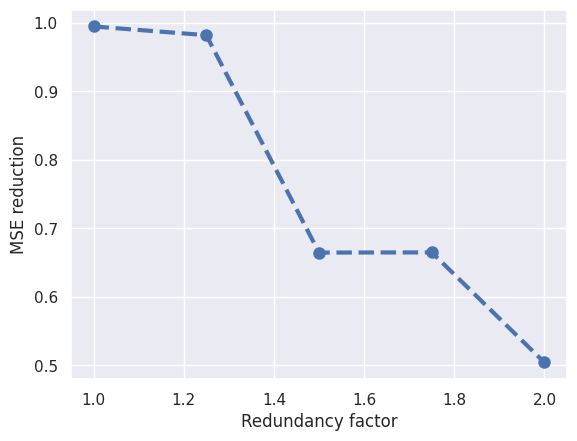

In [154]:
plt.plot(redundancies, mse_reduction, marker='o', linestyle='dashed', linewidth=3, markersize=8)
plt.xlabel('Redundancy factor')
plt.ylabel('MSE reduction')
plt.savefig('noise_exp.png', bbox_inches='tight')
plt.show()

In [109]:
redundancies = [10]
for r in redundancies:
    k = int(2 * r)
    l = 2
    n = 4
    tff = construct_real_tff(k, l// 2, n // 2).view(-1, n)

    latent_dim = int(k*l)
    gen_noise = torch.randn(latent_dim, 1)
    reconst_noise = tff.T @ gen_noise

    gen_noise_energy = (gen_noise ** 2).sum()
    reconst_noise_energy = (reconst_noise ** 2).sum()
    print(f'{k = }, {gen_noise_energy=}, {reconst_noise_energy=}')

k = 20, gen_noise_energy=tensor(48.9735), reconst_noise_energy=tensor(2.0863)


In [108]:
gen_noise = torch.randn(latent_dim, 1)
reconst_noise = tff.T @ gen_noise
print((gen_noise**2).sum())
print((reconst_noise**2).sum())

tensor(40.4903)
tensor(4.5102)


In [38]:
print(tff.T @ tff)

tensor([[ 1.0000e+00,  0.0000e+00, -3.7253e-09, -3.5390e-08],
        [ 0.0000e+00,  1.0000e+00,  3.5390e-08, -3.7253e-09],
        [-3.7253e-09,  3.5390e-08,  1.0000e+00,  0.0000e+00],
        [-3.5390e-08, -3.7253e-09,  0.0000e+00,  1.0000e+00]])


In [16]:
k = 3
l = 2
n = 4
tff = construct_real_tff(k, l// 2, n // 2).view(-1, n)
print(tff)

tensor([[ 0.5774, -0.0000,  0.5774, -0.0000],
        [ 0.0000,  0.5774,  0.0000,  0.5774],
        [ 0.5774, -0.0000, -0.2887, -0.5000],
        [ 0.0000,  0.5774,  0.5000, -0.2887],
        [ 0.5774, -0.0000, -0.2887,  0.5000],
        [ 0.0000,  0.5774, -0.5000, -0.2887]])


In [17]:
projs = tff @ x
projs = projs.view(-1,1)
print(projs.shape)

evergy x = 2.5
energy noise = 0.25
torch.Size([6, 1])


In [18]:
mses = []
for i in range(1):
    ns = torch.randn_like(projs)
    corr_projs = projs + ns
    hat_x = tff.T @ corr_projs
    loss = torch.nn.functional.mse_loss(x, hat_x)
    mses.append(loss.item())

In [19]:
print(mses)

[0.7935652732849121]
